In [2]:
import pandas as pd

# Load ATAC peak × cell matrix
atac = pd.read_csv("./data/ATAC.csv")

# Create a 200bp window around the summit
atac["Start"] = (atac["Summit"] - 100).clip(lower=0).astype(int)
atac["End"] = (atac["Summit"] + 100).astype(int)
atac["Chromosome"] = atac["chrom"]

# Define the correct ILC/NK cell types
cell_types = [
    'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM',
    'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp',
    'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI'
]

# Compute mean accessibility across these cell types
atac["mean_accessibility"] = atac[cell_types].mean(axis=1)


In [3]:
import pandas as pd

tss = pd.read_csv("./data/mmc2.csv")
print(tss.columns.tolist())


['Unnamed: 0', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.IEL.LCMV.d7.Gut', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3

In [4]:
# Load TSS info from refFlat
cols = ["gene", "transcript", "chrom", "strand", "txStart", "txEnd"]
refFlat = pd.read_csv("./data/refFlat.txt", sep="\t", header=None, usecols=range(6), names=cols)

# Compute TSS (strand-aware)
refFlat["tss"] = refFlat.apply(lambda row: row["txStart"] if row["strand"] == "+" else row["txEnd"], axis=1)

# Create TSS DataFrame
tss_df = refFlat[["gene", "chrom", "tss"]].drop_duplicates()
tss_df.columns = ["Gene", "Chromosome", "Start"]
tss_df["Start"] = tss_df["Start"].astype(int)
tss_df["End"] = tss_df["Start"] + 1

In [5]:
# Load TSS data
cols = ["gene", "transcript", "chrom", "strand", "txStart", "txEnd"]
refFlat = pd.read_csv("./data/refFlat.txt", sep="\t", header=None, usecols=range(6), names=cols)

# Compute TSS position
refFlat["tss"] = refFlat.apply(lambda row: row["txStart"] if row["strand"] == "+" else row["txEnd"], axis=1)

# Clean up and rename
tss_df = refFlat[["gene", "chrom", "tss"]].drop_duplicates()
tss_df.columns = ["Gene", "Chromosome", "Start"]
tss_df["Start"] = tss_df["Start"].astype(int)
tss_df["End"] = tss_df["Start"] + 1  # Required for PyRanges


In [8]:
tss = pr.PyRanges(tss_df)


In [7]:
import pyranges as pr

# Convert both to PyRanges
peaks = pr.PyRanges(atac[["Chromosome", "Start", "End", "mean_accessibility"]])
tss = pr.PyRanges(tss_df)

# Find closest TSS
nearest = peaks.nearest(tss, suffix="_tss")
annotated = nearest.df

# Annotate distance and label as promoter/enhancer
annotated["distance_to_tss"] = abs(annotated["Start"] - annotated["Start_tss"])
annotated["annotation"] = annotated["distance_to_tss"].apply(lambda d: "promoter" if d <= 1000 else "enhancer")


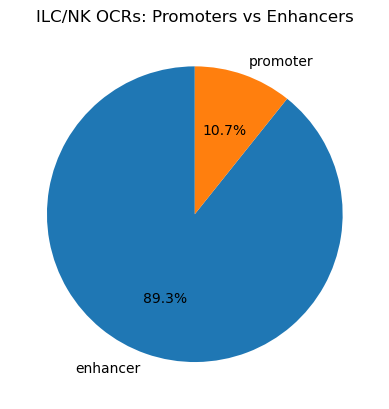

In [9]:
import matplotlib.pyplot as plt

annotated["annotation"].value_counts().plot.pie(autopct="%1.1f%%", startangle=90)
plt.title("ILC/NK OCRs: Promoters vs Enhancers")
plt.ylabel("")
plt.show()


In [15]:
import pandas as pd

atac = pd.read_csv("./data/ATAC.csv")

# Add coordinates
atac["Start"] = (atac["Summit"] - 100).clip(lower=0).astype(int)
atac["End"] = (atac["Summit"] + 100).astype(int)
atac["Chromosome"] = atac["chrom"]

# Define your 10 target cell types
cell_types = [
    'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM',
    'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp',
    'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI'
]
# Ensure annotated has Chromosome, Start, End, Gene_tss
merged = annotated.merge(atac[["Chromosome", "Start", "End"] + cell_types], 
                         on=["Chromosome", "Start", "End"], how="left")



In [20]:
mmc2 = pd.read_csv("./data/mmc2.csv")
print(mmc2.columns.tolist()[:10])

['Unnamed: 0', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'B.FrE.BM', 'B1b.PC']


In [21]:
mmc2 = mmc2.rename(columns={"Unnamed: 0": "Gene"})
gene_expr = mmc2.set_index("Gene")[cell_types]



In [22]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
import pandas as pd

# 1. Extract list of ILC/NK cell types
cell_types = [
    'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM',
    'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp',
    'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI'
]

# 2. Create a pivot table of peaks (CREs) x cell types
# `peaks` must include columns: 'Gene', 'Chromosome', 'Start', 'End', and all 10 cell types
peak_matrix = merged.pivot_table(
    index=["Chromosome", "Start", "End", "Gene"],
    values=cell_types
)

peaks_df = peaks.df  # extract the DataFrame from the PyRanges object

# 3. Create gene expression matrix (rows = gene, cols = cell types)
gene_expr = mmc2.set_index('Gene')[cell_types]  # adjust if Gene is in index

# 4. Run regression per gene
results = []

for gene in gene_expr.index:
    try:
        # Get expression vector (y)
        y = gene_expr.loc[gene].values

        # Get all peaks linked to this gene
        X = peak_matrix.xs(gene, level='Gene', drop_level=False).drop(columns='Gene', errors='ignore').T

        if X.shape[1] < 1:
            continue  # skip genes with no peaks

        # Fit ridge regression
        model = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(X, y)
        y_pred = model.predict(X)

        # Save R²
        results.append({
            "Gene": gene,
            "n_peaks": X.shape[1],
            "R2": r2_score(y, y_pred)
        })
    except Exception:
        continue

# 5. Convert to DataFrame
r2_df = pd.DataFrame(results).sort_values("R2", ascending=False)


In [23]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

results = []

for gene in gene_expr.index:
    try:
        # 1. Expression vector for this gene (10 cell types)
        y = gene_expr.loc[gene].values

        # 2. Get all peaks linked to this gene
        gene_peaks = peak_matrix.xs(gene, level="Gene", drop_level=False).T

        if gene_peaks.shape[1] < 1:
            continue  # skip if no CREs for this gene

        # 3. Run ridge regression (automatically selects best alpha)
        model = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(gene_peaks, y)
        y_pred = model.predict(gene_peaks)

        # 4. Store R²
        results.append({
            "Gene": gene,
            "n_peaks": gene_peaks.shape[1],
            "R2": r2_score(y, y_pred)
        })

    except Exception:
        continue  # in case of bad data or math errors

# 5. Convert to DataFrame and sort
r2_df = pd.DataFrame(results).sort_values("R2", ascending=False)


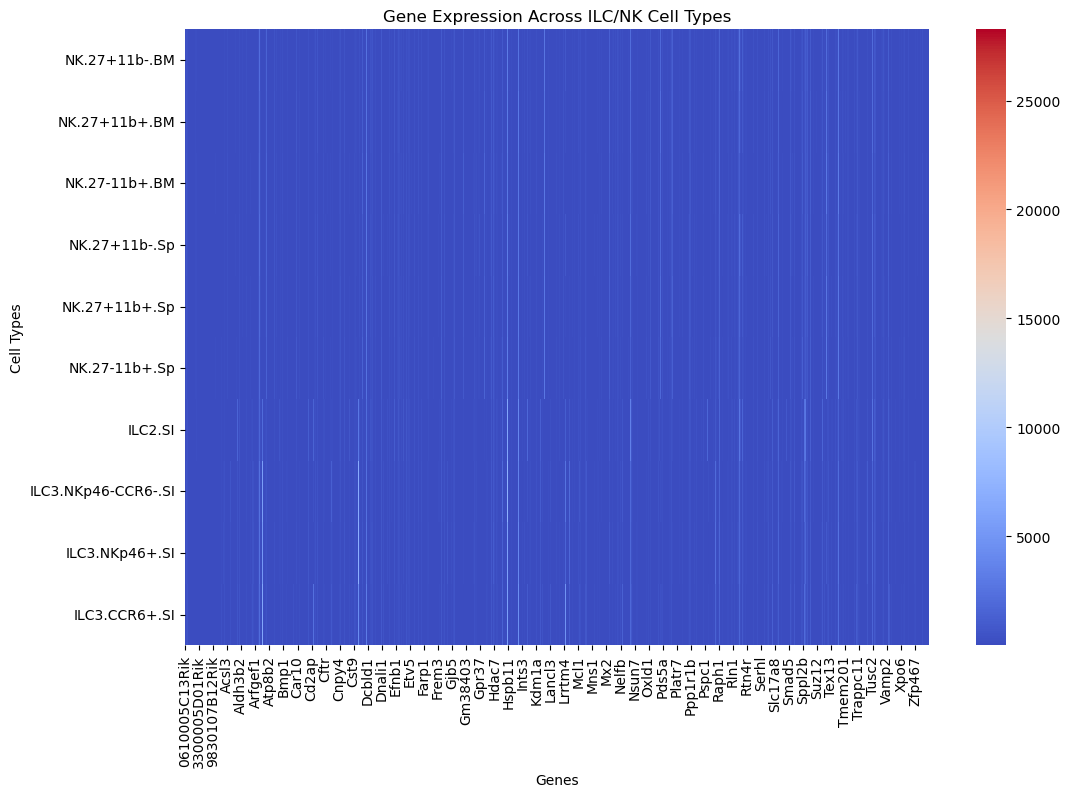

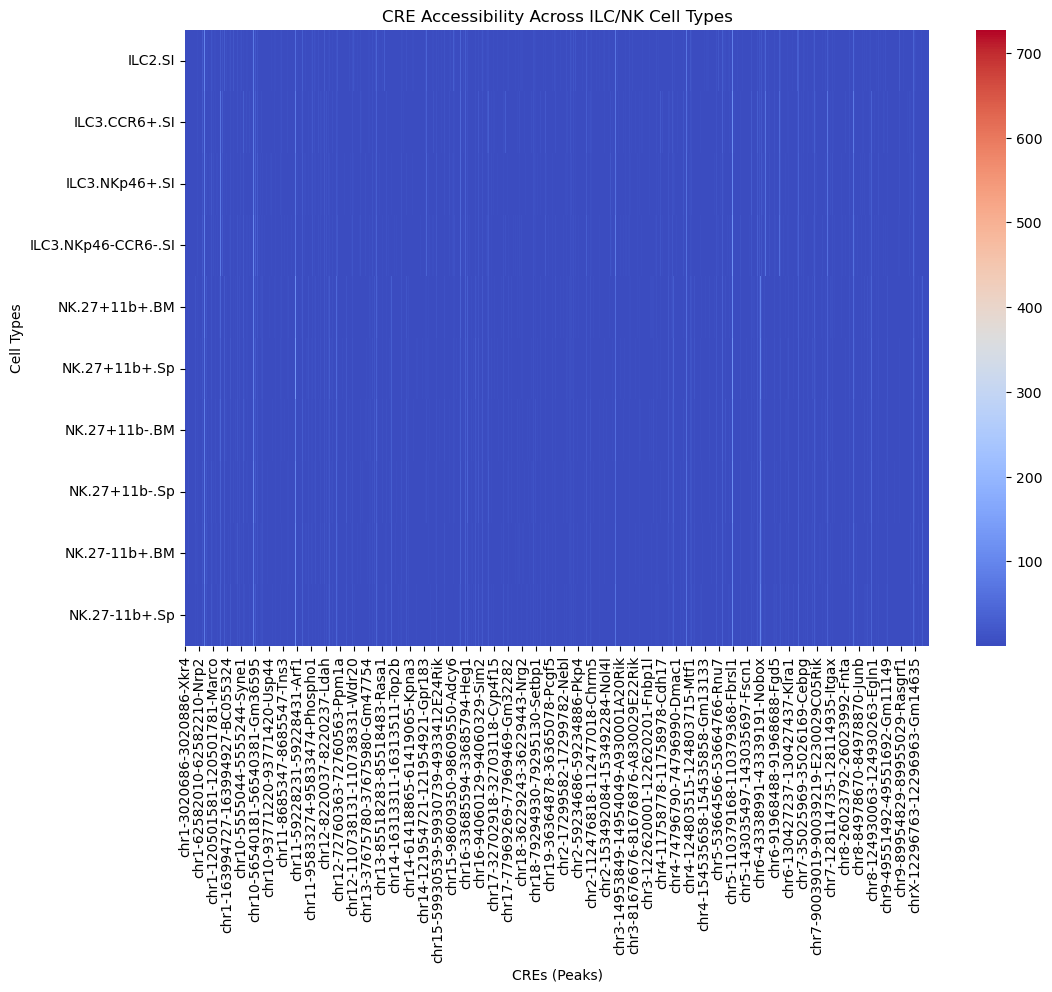

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of gene expression vs accessibility
# Reshape the data: gene expression (rows) x cell types (columns)
expression_matrix = gene_expr.T  # genes as columns, cell types as rows
accessibility_matrix = peak_matrix.T  # CREs as columns, cell types as rows

# Plot heatmap for gene expression across cell types
plt.figure(figsize=(12, 8))
sns.heatmap(expression_matrix, cmap="coolwarm", annot=False, cbar=True)
plt.title("Gene Expression Across ILC/NK Cell Types")
plt.ylabel("Cell Types")
plt.xlabel("Genes")
plt.show()

# Plot heatmap for peak accessibility (CREs) across cell types
plt.figure(figsize=(12, 8))
sns.heatmap(accessibility_matrix, cmap="coolwarm", annot=False, cbar=True)
plt.title("CRE Accessibility Across ILC/NK Cell Types")
plt.ylabel("Cell Types")
plt.xlabel("CREs (Peaks)")
plt.show()


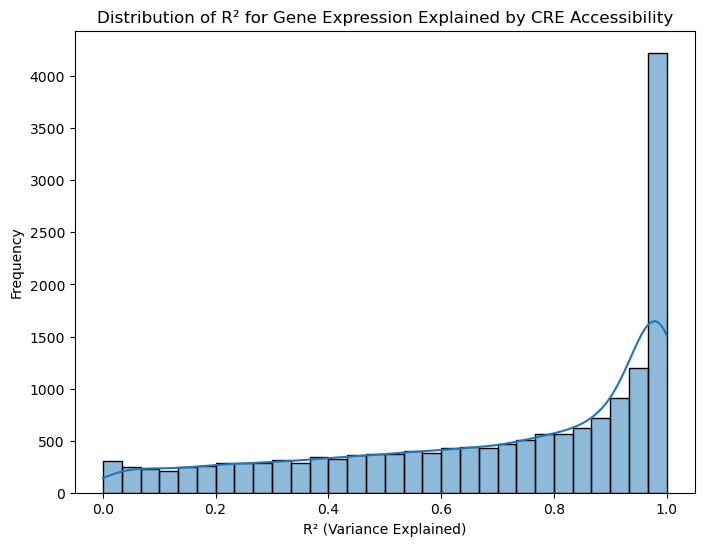

/var/folders/vh/rffjtjt916gdtb214wntxwb80000gn/T/ipykernel_20735/1312859312.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Gene", y="R2", data=top_genes, palette="viridis")


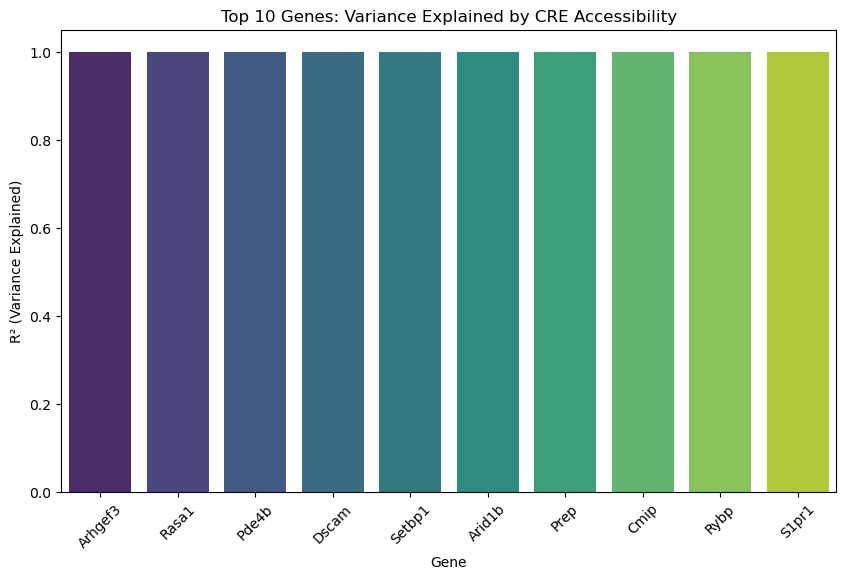

In [25]:
# Plot distribution of R² values
plt.figure(figsize=(8, 6))
sns.histplot(r2_df["R2"], bins=30, kde=True)
plt.title("Distribution of R² for Gene Expression Explained by CRE Accessibility")
plt.xlabel("R² (Variance Explained)")
plt.ylabel("Frequency")
plt.show()

# Plot top 10 genes by R²
top_genes = r2_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x="Gene", y="R2", data=top_genes, palette="viridis")
plt.title("Top 10 Genes: Variance Explained by CRE Accessibility")
plt.xlabel("Gene")
plt.ylabel("R² (Variance Explained)")
plt.xticks(rotation=45)
plt.show()


In [26]:
# Select the top gene with highest R²
top_gene = r2_df.iloc[0]["Gene"]

# Get the expression and accessibility values for this gene
top_gene_expression = gene_expr.loc[top_gene]
top_gene_accessibility = peak_matrix.loc[top_gene]

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(top_gene_accessibility, top_gene_expression)
plt.title(f"Gene Expression vs. CRE Accessibility for {top_gene}")
plt.xlabel("CRE Accessibility")
plt.ylabel("Gene Expression")
plt.show()


KeyError: 'Arhgef3'